In this example a simple SFINCS compound flood model will be made, using Hydromt's inifile input for fast model building

The model is situated in Northern Italy, where a small selection of topography and bathymetry data has already been made available for you to try the examples.

In [3]:
!hydromt --version

hydroMT version: 0.7.0


This example shows how to build a simple SFINCS model on a regular grid, containing an elevation dep-file, offshore water level forcing and an upstream discharge input forcing.
For making a more advanced model including e.g. spatially varying infiltration and roughness, see the example notebook: build_advanced_subgrid_compound_model_from_script.ipynb

In case you want to adjust this example to build a SFINCS model anywhere else in the world, you will have to add your own datasets to HydroMT's data catalog. For more info on that, see the example notebook: example_datasources.ipynb

Steps followed in this notebook to build your SFINCS model:
<ul> 
<li> 1. Build your first SFINCS model </li>
<li> 2. Check what files have been created </li>
<li> 3. Information about created files </li>
<li> 4. Plot current base model </li>
<li> 5. Explanation of HydroMT's .ini-file </li>
<li> 6. Make new model including forcing </li>
<li> 7. Plot model including forcing </li>
<li> 8. Check what additional files have been created </li>
</ul> 

Let's get started!

1. Build your first SFINCS model:

In [4]:
!hydromt build sfincs ./sfincs_simple_compound_base --region "{'geom': 'data/region.geojson'}" -i sfincs_simple_compound_base.ini --force-overwrite

0 gaps outside valid elevation range < 10 km2.
2023-03-16 16:22:10,148 - build - model_api - WARNING - Replacing geom: region
2023-03-16 16:22:10,161 - build - model_api - WARNING - Replacing geom: region


Explanation of what is provided:

* `!hydromt build sfincs` : we want HydroMT to build a SFINCS model, the '!' is added so you can run the command line command in this python notebook
* `./sfincs_simple_compound_base` : we want HydroMT to build this model in a folder called "sfincs_simple_compound_base"
* `--region "{'geom': 'data/region.geojson'}"` : we want to define the region to build a model for based on a geometry, which is already defined for you in the file "data/region.geojson"
* `-i sfincs_simple_compound_base.ini` : the conditions of how to build the model are prescribed in the file "-i "sfincs_simple_compound.ini", we'll take a look at that one soon
* `--force-overwrite` : means that even if there's already an existing folder with the same name and SFINCS input files, HydroMT will overwrite it

In [5]:
# NOTE: instead of '--region', you can also type '-r'
# NOTE: instead of '--force-overwrite', you can also type '--fo'
# NOTE: for extra output information of HydroMT's logfile command, add '-v'

In [6]:
# For more information on command line available options, type:
!hydromt build --help

Usage: hydromt build [OPTIONS] MODEL MODEL_ROOT

  Build models from scratch.

  Example usage:
  --------------

  To build a wflow model for a subbasin using and point coordinates snapped to cells with stream order >= 4
  hydromt build wflow /path/to/model_root -i /path/to/wflow_config.ini -r "{'subbasin': [-7.24, 62.09], 'strord': 4}" -d deltares_data -d /path/to/data_catalog.yml -v

  To build a sfincs model based on a bbox
  hydromt build sfincs /path/to/model_root  -i /path/to/sfincs_config.ini -r "{'bbox': [4.6891,52.9750,4.9576,53.1994]}" -d /path/to/data_catalog.yml -v

Options:
  --opt TEXT               Method specific keyword arguments, see the method
                           documentation of the specific model for more
                           information about the arguments.
  -i, --config PATH        Path to hydroMT configuration file, for the model
                           specific implementation.
  -r, --region TEXT        Set the region for which to build the mo

**IMPORTANT NOTE on ".ini-file" for existing SFINCS users!**

Note that the naming ".ini-file" of HydroMT has NOTHING to do with SFINCS input file called inifile for spatially varying initial water level input!
(for SFINCS' inifile explanation, see also: https://sfincs.readthedocs.io/en/latest/input.html#initial-water-level)

2. Check what files have been created:

In [7]:
# !ls ./sfincs_simple_compound #TL: 'ls' is not recognized as an internal or external command, operable program or batch file.
import os

dir_list = os.listdir('./sfincs_simple_compound_base')
print(dir_list)

['gis', 'hydromt.log', 'hydromt_data.yml', 'sfincs.dep', 'sfincs.ind', 'sfincs.inp', 'sfincs.msk']


3. Information about created files:

**SFINCS native input files:**

* `sfincs.inp`: https://sfincs.readthedocs.io/en/latest/input.html#overview
    - which includes the grid: https://sfincs.readthedocs.io/en/latest/input.html#grid-characteristics
* `depfile: sfincs.dep` : https://sfincs.readthedocs.io/en/latest/input.html#depth-file
* `mskfile: sfincs.msk` : https://sfincs.readthedocs.io/en/latest/input.html#mask-file
* `indfile: sfincs.ind` : https://sfincs.readthedocs.io/en/latest/input.html#index-file

Go through the links in case you want to have more information about what each file means!

**HydroMT output:**
* `folder 'gis'` : contains tiff- and geojson-files of the input files of SFINCS, for you to easily check in your favourite GIS application
* `hydromt.log` : log-file with feedback of HydroMT during building your model
* `hydromt_data.yml` : summary of the datasets used in building your model, in one handy overview yaml-file

4. Plot current base model

D:\repos\hydromt_sfincs\hydromt_sfincs\hydromt_sfincs\sfincs.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


(<Figure size 1300x700 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'SFINCS dep map'}, xlabel='x coordinate UTM zone 33N [m]', ylabel='y coordinate UTM zone 33N [m]'>)

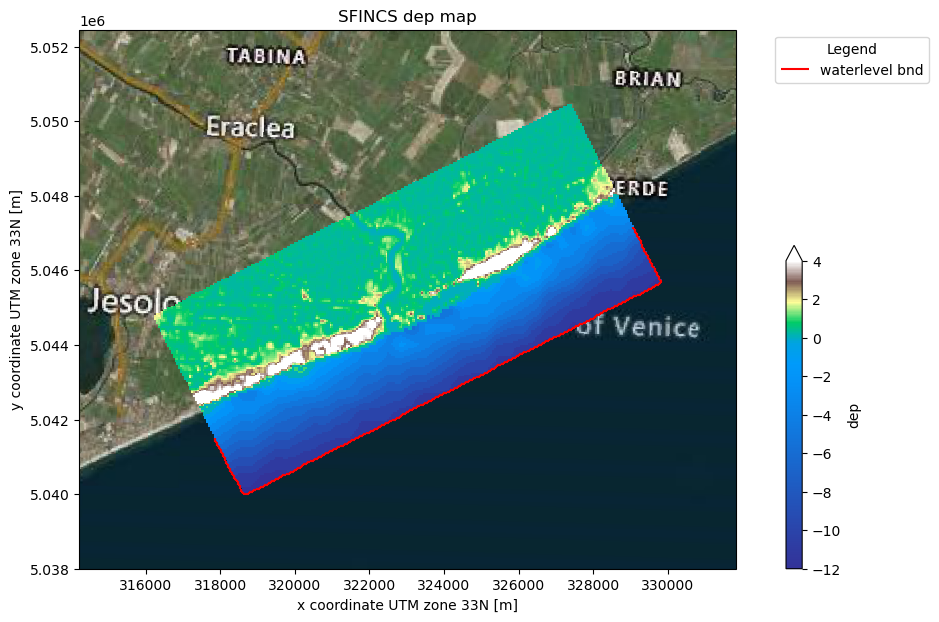

In [8]:
from hydromt_sfincs import SfincsModel
root = r'./sfincs_simple_compound_base'

# read the model with hydromt methods
sf = SfincsModel(root=root, mode="r")
sf.read()
sf.plot_basemap(figsize=(13, 7), shaded=False)

In [9]:
# Here in the plot you see the following:
# - Background geoimage of the region
# - Spatial colourplot of the elevation (dep)
# - In the red line of 'waterlevel bnd' the boundary cells along which SFINCS will later force input water levels

# NOTE - While you see a rotated-looking-grid, the actual rotation in 'sfincs.inp' is still set to 0
# This is totally fine for a simple example case. 
# In case you're making a more advanced model including forced waves, it is better to make an actual rotated grid, so that waves are forced perpendicular to the shoreline

5. Explanation of HydroMT's .ini-file:

This model was made using HydroMT's inifile, in this case 'sfincs_simple_compound_temp.ini, that contains:

In [10]:
fn_ini = "sfincs_simple_compound_base.ini"
with open(fn_ini, "r") as f:
    txt = f.read()
print(txt)

[setup_config]
tref = 20100201 000000
tstart = 20100201 000000
tstop = 20100202 000000

[setup_grid_from_region]
res = 50                      # model resolution
crs = utm                      # model CRS (must be UTM zone)

[setup_dep]
datasets_dep = [{"dep_fn":"merit_hydro"}, {"dep_fn": "gebco"}]

[setup_mask_active]
include_mask_fn = "data//region.geojson"

[setup_mask_bounds]
btype = "waterlevel"
elv_max = -5


You can see the following sections:

* `[setup_config]`: arguments which are forwarded to the SFINCS model configuration file sfincs.inp, in this case the reference time 'tref', model start time 'tstart' and end time 'tstop'
* `[setup_grid_from_region]`: arguments used to create a model grid from the region you provided; in this case grid resolution of 50 meters (res = 50) and the request of the models Coordinate Reference System (CRS) in a UTM zone (crs = utm). The exact UTM zone is automatically found by HydroMT
* `[setup_dep]`: Here you may add the elevation and bathymetry data to the model domain. If using local data sources, these then have to be supplied in the `data_catalog.yml`. At least one dataset is required. Additional data sources for bathymetry data are merged with the first elevation dataset using merge argements if provided.
* `[setup_mask_active]`: set valid model cells based on an input region file (more options available).
* `[setup_make_bounds]`: set cells at the model domain edge and up to an elevation of -5 meters (elv_max = -5) to waterlevel boundary cells.

From here on, we're going to extend the model with some forcing of water level and river discharge, so that actually something interesting will happen when you run the created SFINCS model later. Also, we're adding some observations points so we can inspect this. We do this with the additional inifile **sfincs_simple_compound_update.ini** containing what we want to add:

6. Make new model including forcing:

In [15]:
!hydromt update sfincs ./sfincs_simple_compound_base -o ./sfincs_simple_compound_forcing -i sfincs_simple_compound_update.ini 

The example above means the following: run **hydromt** with:

- `update sfincs`: i.e. update a sfincs model
- `./sfincs_simple_compound_base`: original model folder
- `-o ./sfincs_simple_compound_forcing`: output updated model folder
- `-i sfincs_simple_compound_update.ini`: setup configuration file containing the components to update and their different options

In [16]:
# Let's see what is in the inifile:

fn_ini = "sfincs_simple_compound_update.ini"
with open(fn_ini, "r") as f:
    txt = f.read()
print(txt)

[setup_observation_points]
obs_fn = "data//compound_example_observation_points.shp"

[setup_waterlevel_forcing]
geodataset_fn = gtsmv3_eu_era5

#[setup_discharge_forcing]
#geodataset_fn = data/compound_src_locations.csv
#timeseries_fn = data/compound_dis_timeseries.csv


You can see the following sections:

* `[setup_observation_points]`: arguments used to add 3 observation points, based on the locations as given in the shapefile "data//compound_example_observation_points.shp"
* `[setup_waterlevel_forcing]`: arguments used to add water level forcing, in this case water levels from a GTSM run, with 4 observation points found in the SFINCS model domain, and clipped automatically to the earlier provided wanted start and stop time of the SFINCS model (in setup_config)
* `[setup_discharge_forcing]`: arguments used to add a upstream river discharge input point, in this case from two csv files

7. Plot model including forcing:

(<Figure size 1300x700 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'SFINCS dep map'}, xlabel='x coordinate UTM zone 33N [m]', ylabel='y coordinate UTM zone 33N [m]'>)

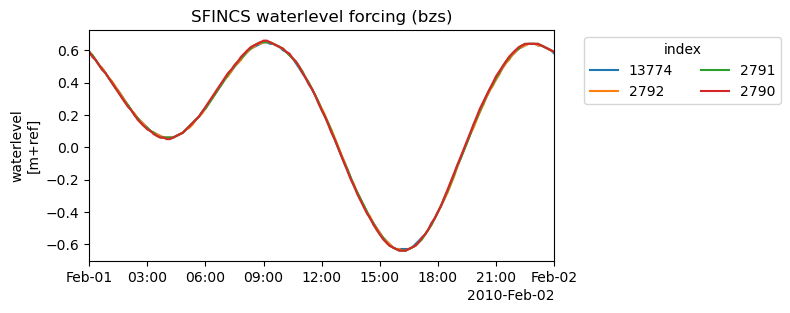

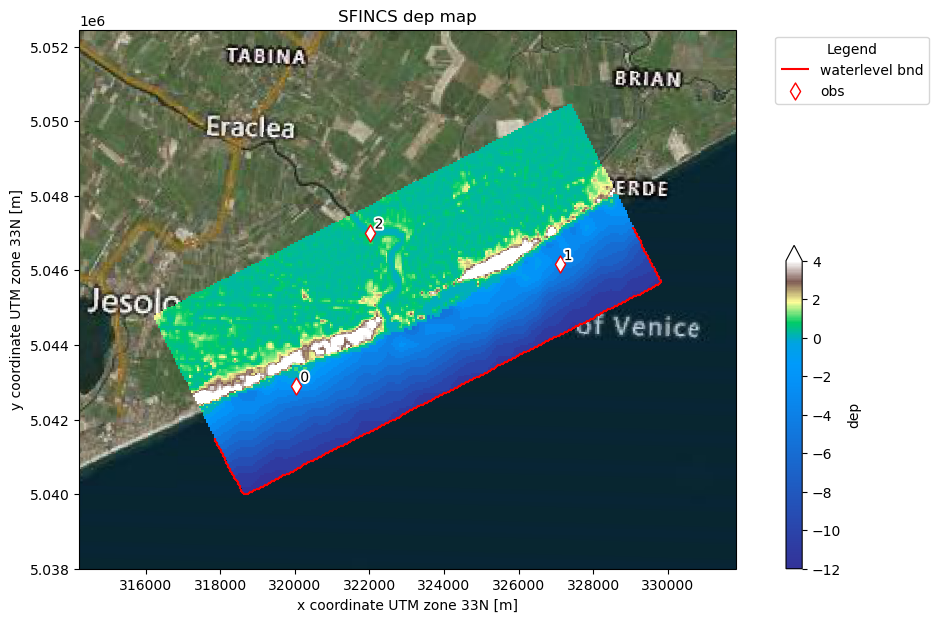

In [18]:
root = r'./sfincs_simple_compound_forcing'
# read the model with hydromt methods
sf = SfincsModel(root=root, mode="r")
sf.read()

# Plot time-series:
sf.plot_forcing()

sf.plot_basemap(figsize=(13, 7), shaded=False)


In [ ]:
# Here in the 1st plot you see the following:
# - Water level time-series from GTSM input, for the model period, for the 4 found stations in the SFINCS domain region
#   these time-series are forced along the 'waterlevel bnd' boundary cells, see plot below

# Here in the 2nd plot you see the following:
# - Background geoimage of the region
# - Spatial colourplot of the elevation (dep)
# - In the red line of 'waterlevel bnd' the boundary cells along which SFINCS will later force input water levels
# - Specified observation points 'obs' in red diamond to get a 'sfincs_his.nc' output file

8. Check what additional files have been created:

In [19]:
dir_list = os.listdir('./sfincs_simple_compound_forcing')
print(dir_list)

['figs', 'gis', 'hydromt.log', 'hydromt_data.yml', 'sfincs.bnd', 'sfincs.bzs', 'sfincs.dep', 'sfincs.ind', 'sfincs.inp', 'sfincs.msk', 'sfincs.obs']


**SFINCS native input files:**
* `obsfile: sfincs.obs`: : https://sfincs.readthedocs.io/en/latest/input.html#observation-points
* `bndfile: sfincs.bnd` : https://sfincs.readthedocs.io/en/latest/input_forcing.html#water-level-points
* `bzsfile: sfincs.bzs` : https://sfincs.readthedocs.io/en/latest/input_forcing.html#water-level-time-series
* `srcfile: sfincs.src`: https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-points
* `disfile: sfincs.dis`: https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-time-series

Go through the links in case you want to have more information about what each file means!

In case you want to add other types of forcing, see the example notebook example_forcing.ipynb for other types.

Or have a look at: https://sfincs.readthedocs.io/en/latest/input_forcing.html

Overview of all available options in Hydromt-SFINCS: https://deltares.github.io/hydromt_sfincs/latest/user_guide/sfincs.html

In [ ]:
# NOTE - HydroMT can build even more models for you, like the Hydrological model Wflow, 
# to provide for instance upstream boundary conditions for your SFINCS model!
# See e.g: https://deltares.github.io/hydromt/latest/plugins.html

Now you have made a model, you can progress to the notebook: run_sfincs_model.ipynb